<a href="https://colab.research.google.com/github/nojihun/project1/blob/main/captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os.path
import numpy as np
import imageio
import cv2
from skimage import color, io
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from PIL import Image
from pathlib import Path

In [ ]:
drive.mount('/content/drive') # 구글 드라이브에 연동

Mounted at /content/drive


In [ ]:
directory1 = '/content/drive/MyDrive/captcha'
file_list1 = os.listdir(directory1)# 구글 드라이브에서 폴더 읽기


In [ ]:
data_dir = Path(directory1)

type(data_dir)

pathlib.PosixPath

In [ ]:
X=[]
y=[]

# Since there are subfolders inside the input directory, we've used nested loops
for dirname, _, filenames in os.walk(directory1):
    for filename in filenames[:10000]:
        path=os.path.join(dirname, filename) 
        
# Preprocessing the image:
# - read image
        image = cv2.imread(path,cv2.IMREAD_COLOR)


# - Blur: As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc.
# LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.
        image = cv2.GaussianBlur(image, (5,5), 0)
 

# Splitting up the image into sections of each character
        x=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

# Labelling segments with the image name
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i])))
            y.append(path[len(path)-9:len(path)-4][i])
X=np.array(X)
y=np.array(y)


In [ ]:
X=X.astype('float32')
X/=255

y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

In [ ]:
y.shape
X.shape

(50000, 30, 20, 3)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), padding ='same'))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), padding ='same'))


model.add(Conv2D(filters=128,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2,2), padding ='same'))



model.add(Flatten())
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 20, 16)        448       
                                                                 
 activation (Activation)     (None, 30, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 15, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 5, 16)         0         
 2D)                                                    

In [ ]:
from keras.callbacks import EarlyStopping


batch_size = 150
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[es])

Epoch 1/200
267/267 [==============================] - 7s 18ms/step - loss: 3.9233 - accuracy: 0.0685 - val_loss: 3.7869 - val_accuracy: 0.1136
Epoch 2/200
267/267 [==============================] - 4s 14ms/step - loss: 3.6150 - accuracy: 0.1452 - val_loss: 3.4356 - val_accuracy: 0.1966
Epoch 3/200
267/267 [==============================] - 4s 14ms/step - loss: 3.2134 - accuracy: 0.2271 - val_loss: 3.0705 - val_accuracy: 0.2624
Epoch 4/200
267/267 [==============================] - 4s 14ms/step - loss: 2.9156 - accuracy: 0.2884 - val_loss: 2.8336 - val_accuracy: 0.3146
Epoch 5/200
267/267 [==============================] - 4s 13ms/step - loss: 2.7132 - accuracy: 0.3326 - val_loss: 2.6771 - val_accuracy: 0.3569
Epoch 6/200
267/267 [==============================] - 4s 15ms/step - loss: 2.5618 - accuracy: 0.3658 - val_loss: 2.5625 - val_accuracy: 0.3861
Epoch 7/200
267/267 [==============================] - 4s 14ms/step - loss: 2.4439 - accuracy: 0.3894 - val_loss: 2.4740 - val_accuracy:

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 7ms/step - loss: 3.4359 - accuracy: 0.4810
Test loss: 3.435868740081787
Test accuracy: 0.48100000619888306


In [ ]:
def pred (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    image = cv2.GaussianBlur(img, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

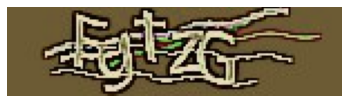

Prediction: ngfzq
Actual:     FgfzG


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

pred(directory1+'/'+'FgfzG.jpg')

In [ ]:
img= []
count = 0
for file in file_list1[:10000]: # 폴더에 있는 captcha 사진들을 읽어와서 1과 0으로 변환. 사진이 만장이라 좀 많이 오래 걸림
  image = io.imread(directory1+'/'+ file)  
  img.append(image)

In [ ]:
type(img)

list

In [ ]:
train = np.array(img)#리스트 였던 데이터를 array 배열로 변환. 
train = train/255
train.shape

(10000, 40, 150, 3)

In [ ]:
y = file_list1[:10000]#라벨이 될 파일의 이름들.
y = np.array(y)


In [ ]:
for i in range(len(y)): #이름에 글자만 남기기 위해서 확장자 명인.jpg를 없애 준다.
  y[i] = y[i].replace('.jpg','')
  print(y[i])

In [ ]:
characters = set(ch for label in y for ch in label)

In [ ]:
print("Total number of unique characters: ", len(characters))
print("Characters: ", characters)

Total number of unique characters:  60
Characters:  {'E', 'O', 'g', 'N', 'f', 'a', 'h', 'v', 'l', 't', 'i', 'p', 'r', 'y', 'm', '4', 'I', 'R', 'X', 'G', 'q', '9', 'K', 'A', 'w', 'C', 'd', 'e', 'Y', '5', 'J', 'z', 'H', '3', 'x', '6', 'c', 'P', 'T', 'D', 'F', 'Z', 'n', 's', 'U', 'j', 'b', 'W', 'B', 'S', 'V', 'u', '2', 'L', 'k', '8', 'M', 'Q', '1', '7'}


In [ ]:
encoder = LabelEncoder()
y_le = encoder.fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

In [ ]:
print(train.shape)
print(y_ohe[:,1].shape)

(10000, 40, 150, 3)
(10000,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, y_ohe, test_size = 0.15, random_state = 42)# 만개의 데이터를 훈련, 검증, 시험 데이터로 나눈다.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(6800, 40, 150, 3) (1700, 40, 150, 3) (1500, 40, 150, 3)
(6800, 10000) (1700, 10000) (1500, 10000)


array([0., 0., 0., ..., 0., 0., 0.])

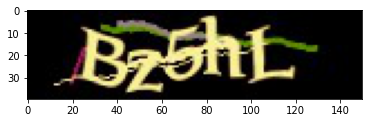

In [ ]:

import matplotlib.pyplot as plt # 이름과 파일이 제대로 섞여있는가 확인
plt.imshow(x_val[150])
y_val[150]

0.0

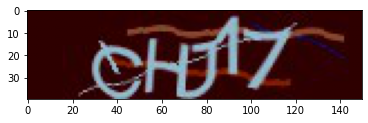

In [ ]:
plt.imshow(x_train[1000])
y_train[1000]

In [ ]:
y_train.shape

(6800,)

In [ ]:
categories = y_ohe.shape[1]

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(40,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 40, 150, 16)       448       
                                                                 
 activation (Activation)     (None, 40, 150, 16)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 75, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 75, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 37, 16)       0         
 2D)                                                  

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 150
epochs = 200

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True)

Epoch 1/200
 2/46 [>.............................] - ETA: 2s - loss: 8.8784 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])